In [1]:
import numpy as np
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import time
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

from google.colab import drive
drive.mount('/content/drive')

import tensorflow.keras as keras

Mounted at /content/drive


Step 0, Loss: 3944674.5
Step 100, Loss: 3366023.75
Step 200, Loss: 2990831.0
Step 300, Loss: 2720607.5
Step 400, Loss: 2522536.75
Step 500, Loss: 2375432.5
Step 600, Loss: 2264214.25
Step 700, Loss: 2178324.0
Step 800, Loss: 2110358.5
Step 900, Loss: 2055330.75
Step 1000, Loss: 2010234.75
Step 1100, Loss: 1972725.75
Step 1200, Loss: 1940975.25
Step 1300, Loss: 1913883.25
Step 1400, Loss: 1890564.25


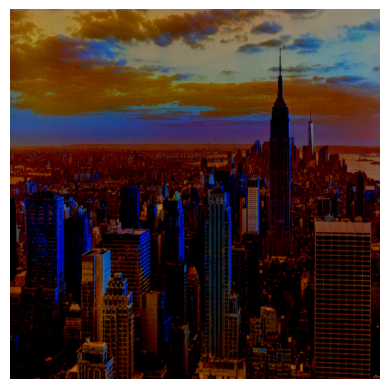

In [8]:
# Load and preprocess the images
content_image_path = '/content/drive/My Drive/Colab Notebooks/projects/artistic_style_transfer/content_image-1.jpg'
style_image_path = '/content/drive/My Drive/Colab Notebooks/projects/artistic_style_transfer/style_image-1.jpg'

# Function to preprocess image for VGG19
def load_and_process_image(img_path, target_size=(1024,1024)):
    img = Image.open(img_path).resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

# Load VGG19 model
vgg = VGG19(weights='imagenet', include_top=False)

# Extracting low-level features for style and high-level features for content
low_level_layers = ['block1_conv1','block1_conv2', 'block2_conv1','block2_conv2']
low_level_outputs = [vgg.get_layer(layer).output for layer in low_level_layers]
style_model = Model(inputs=vgg.input, outputs=low_level_outputs)
low_level_features = style_model(style_image)

high_level_layers = ['block3_conv1','block3_conv3','block3_conv4','block4_conv1','block4_conv2','block4_conv4','block5_conv2','block5_conv3']
high_level_outputs = [vgg.get_layer(layer).output for layer in high_level_layers]
content_model = Model(inputs=vgg.input, outputs=high_level_outputs)
high_level_features = content_model(content_image)

# Initialize combination image with content
combination_image = tf.Variable(content_image, dtype=tf.float32)

# Function to calculate Gram matrix for style loss
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    tensor = tf.reshape(tensor, [-1, channels])
    gram = tf.matmul(tensor, tensor, transpose_a=True)
    return gram / tf.cast(tf.shape(tensor)[0], tf.float32)

# Updated loss functions to handle lists of features
def content_loss(content_features, combination_features):
    # Compute the mean of squared differences for each layer's features and sum them
    return tf.reduce_sum([tf.reduce_mean(tf.square(c - comb)) for c, comb in zip(content_features, combination_features)])

def style_loss(style_features, combination_features):
    # Compute the mean of squared differences of Gram matrices and sum them
    return tf.reduce_sum([tf.reduce_mean(tf.square(gram_matrix(s) - gram_matrix(comb))) for s, comb in zip(style_features, combination_features)])

def total_variation_loss(image):
    a = tf.square(image[:, :-1, :-1, :] - image[:, 1:, :-1, :])
    b = tf.square(image[:, :-1, :-1, :] - image[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Total loss function combining content, style, and total variation losses
def total_loss(content_features, style_features, comb_content_features, comb_style_features, combination_image, content_weight, style_weight, variation_weight):
    content_loss_value = content_loss(content_features, comb_content_features)
    style_loss_value = style_loss(style_features, comb_style_features)
    variation_loss_value = total_variation_loss(combination_image)
    return (content_weight * content_loss_value +
            style_weight * style_loss_value +
            variation_weight * variation_loss_value)

# Weights for losses
content_weight = 1e1
style_weight = 1e-3
variation_weight = 1e-4

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.05)

# Optimization loop
epochs = 1500
for i in range(epochs):
    with tf.GradientTape() as tape:
        comb_content_features = content_model(combination_image)
        comb_style_features = style_model(combination_image)
        loss = total_loss(high_level_features, low_level_features, comb_content_features, comb_style_features, combination_image, content_weight, style_weight, variation_weight)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])

    if i % 100 == 0:
        print(f'Step {i}, Loss: {loss.numpy()}')

# Display final image
def display_image(image_tensor):
    img = image_tensor.numpy().squeeze()
    img = np.clip(img, 0, 255).astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

display_image(combination_image)

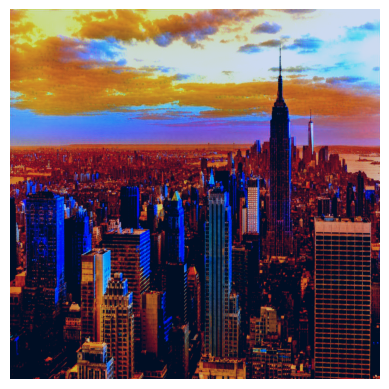

In [11]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

# Display final image with brightness and contrast adjustments
def display_image(image_tensor, brightness_factor=2.2, contrast_factor=1.0, color_factor=1.1, hue_shift=1, cool_intensity=0.2):
    # Convert the tensor to a numpy array and clip values
    img = image_tensor.numpy().squeeze()
    img = np.clip(img, 0, 255).astype('uint8')

    # Convert the numpy array to a PIL image for enhancement
    img = Image.fromarray(img)

    # Adjust brightness
    brightness_enhancer = ImageEnhance.Brightness(img)
    img = brightness_enhancer.enhance(brightness_factor)

    # Adjust contrast
    contrast_enhancer = ImageEnhance.Contrast(img)
    img = contrast_enhancer.enhance(contrast_factor)

    # Adjust hue
    img = img.convert("HSV")
    hsv_array = np.array(img)
    hsv_array[:, :, 0] = (hsv_array[:, :, 0] + hue_shift) % 256
    img = Image.fromarray(hsv_array, "HSV").convert("RGB")

    # Add a cooling effect by blending in blue tones
    blue_overlay = Image.new("RGB", img.size, (0, 70, 180))  # cool blue tone
    img = Image.blend(img, blue_overlay, cool_intensity)  # blend with cool tone

    # Display the final image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Call the function with your image tensor and adjusted factors
display_image(combination_image)